##             Stock market prediction with LSTM 

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler


1. Downloading and explorating the data

In [4]:
 df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
print('Loaded data from the Kaggle repository')

Loaded data from the Kaggle repository


In [9]:
df=df.sort_values('Date')
df.head(10)

Date     Open     High      Low    Close
0  1970-01-02  0.30627  0.30627  0.30627  0.30627
1  1970-01-05  0.30627  0.31768  0.30627  0.31385
2  1970-01-06  0.31385  0.31385  0.30996  0.30996
3  1970-01-07  0.31385  0.31385  0.31385  0.31385
4  1970-01-08  0.31385  0.31768  0.31385  0.31385
5  1970-01-09  0.31385  0.31768  0.31385  0.31768
6  1970-01-12  0.31768  0.32534  0.31768  0.32534
7  1970-01-13  0.32534  0.32916  0.32152  0.32152
8  1970-01-14  0.32152  0.32534  0.31768  0.32152
9  1970-01-15  0.32152  0.32916  0.32152  0.32916

2. Data visualazation 

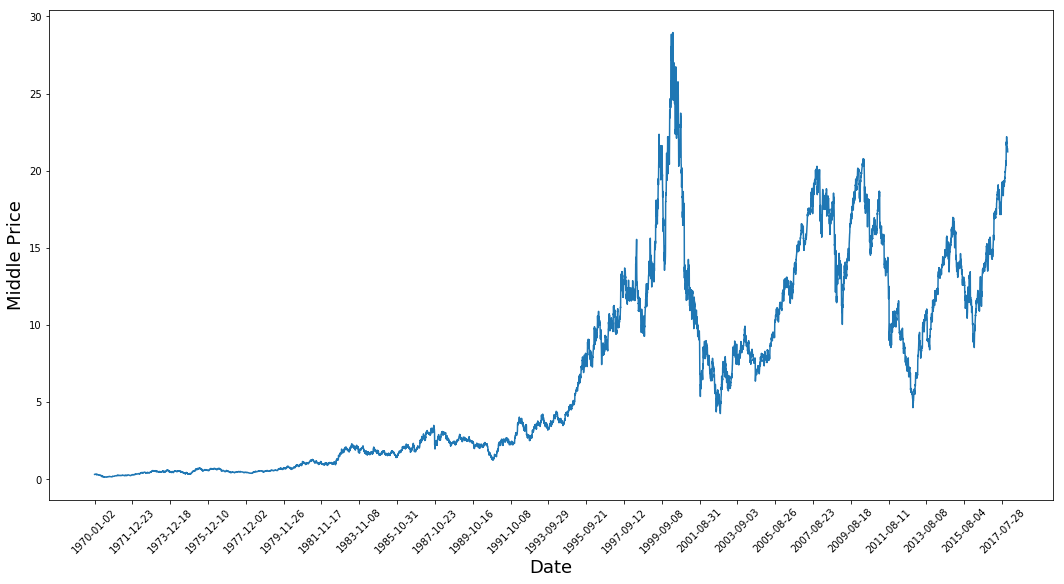

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Middle Price',fontsize=18)
plt.show()


3. Training and test datas

In [7]:
high_prices = np.array(df.loc[:,'High'])
low_prices = np.array(df.loc[:,'Low'])
mid_prices = (high_prices+low_prices)/2.0
mid_prices 

array([ 0.30627 ,  0.311975,  0.311905, ..., 21.355   , 21.275   ,
       21.225   ])

In [8]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

4. Normalizing/smooting the Data 

In [14]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [16]:
EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA
    
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [15]:
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])
    
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])
train_data = train_data.reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

5. Prediction one step ahead 

5. 1  With Averaging

To predict the future stock price one step ahead, we can just take the average of some previous stock prices observed. It is called the standard average prediction. From this predicted data, we can calculate the mean square error between predicted values and true values and averaging it for all the predictions. 

In [17]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00430


Now we can plot the predictions: 

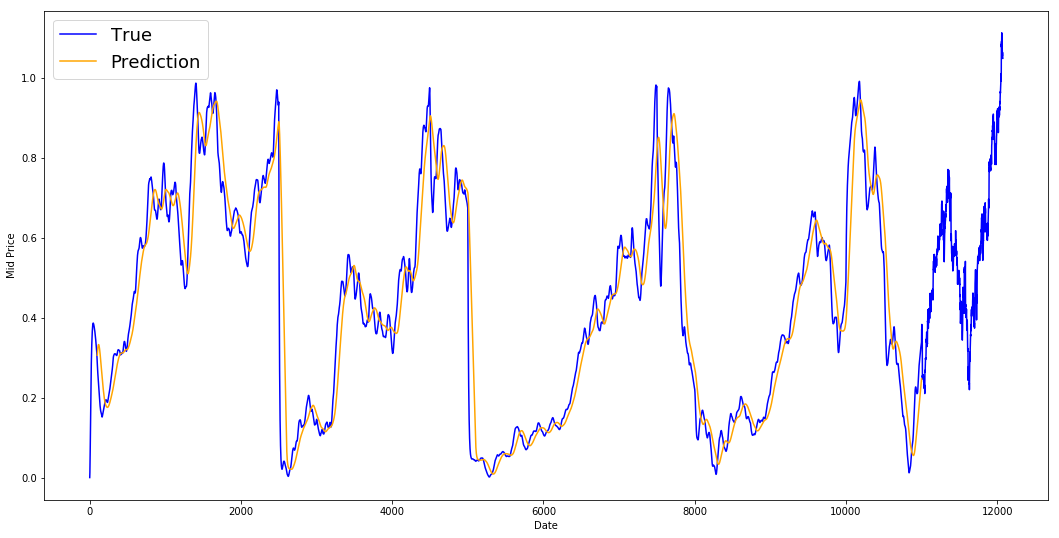

In [18]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

5. 2  With exponential moving average 

We can also use the exponantial moving average, which consist in calculating the prediction using a exponential moving average value which remains the same over time.

In [19]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00002


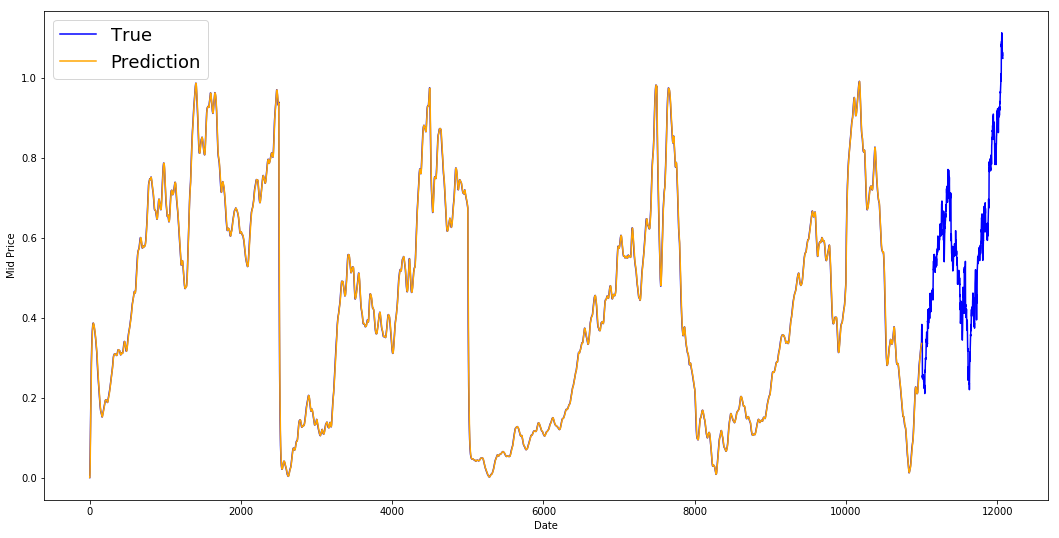

In [20]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

6. Predictions more than one step ahead: LSTM

The Long Short-Term Memory model are very useful in order to predict more than one step in the future. This model works like neural networks with 5 component. 

6.1  Data Generator 

First of all we are going to create a class called data generator to train our model 

In [21]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.         0.74264216 0.8364027  0.33881465 0.1075149 ]

	Output: [0.03447095 0.74471134 0.84622854 0.3451819  0.1075149 ]


Unrolled index 1
	Inputs:  [0.00421877 0.7435816  0.8415513  0.34034798 0.10793295]

	Output: [0.04843011 0.7435816  0.85770345 0.34034798 0.10916119]


Unrolled index 2
	Inputs:  [0.01181149 0.7442261  0.84622854 0.3419687  0.10848684]

	Output: [0.01181149 0.7450629  0.85770345 0.3419687  0.11045941]


Unrolled index 3
	Inputs:  [0.02209037 0.74471134 0.85043985 0.3435819  0.10916119]

	Output: [0.03447095 0.7450629  0.8608688  0.3451819  0.10982503]


Unrolled index 4
	Inputs:  [0.03447095 0.7450629  0.8542759  0.3451819  0.10982503]

	Output: [0.03447095 0.7452733  0.8542759  0.3466938  0.11231996]


6.2 Defining hyperparameters 

In [ ]:
D = 1 # Dimensionality of the data. Since the data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we are using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount


6.3 Defining inputs and outputs

In [24]:

train_inputs, train_outputs = [],[]

#Unrolling the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

NameError: name 'tf' is not defined

In [ ]:
6.4 Defining parameters of LSTM 

In [ ]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))